# Part 1

This notebook documents an in-depth analysis of the 2024 data engineer salaries dataset obtained from [Kaggle](https://www.kaggle.com/datasets/chopper53/data-engineer-salary-in-2024). Utilizing Apache Spark within Databricks, the analysis covers data ingestion, transformation, and visualization to derive meaningful insights.

# Objectives for Data Analysis
**1. Dataset Setup and Inspection:**

* Accessed AWS S3 to load the 2024 data engineer salaries dataset.
* Displayed the first 10 records of the dataset.

**2. Table Creation and SQL Queries:**

* Created `salaries_table` in Spark SQL.
* Executed SQL queries to analyze average salary by job title, max salary by experience level, and count employees by company size.

**3. Visualizations:**

* Line chart: Average salary over time.
* Bar charts: Average salary by experience level, remote work ratio by company size, job titles, and top countries.
* Scatter plot: Average salary vs. remote work ratio for top countries.

**4. Data Transformations:**

* Filtered, selected, limited, and ordered the dataset.
* Grouped by job title with aggregation functions.
* Calculated min/max salaries, distinct job titles, and salary-remote ratio correlation.
* Created a widget for country filtering.
* Filled null values in `remote_ratio` with the mean.
* Added `is_full_time` column based on `employment_type`.
* Wrote DataFrame in Delta format and created a temporary view.

**5. Performance Analysis:**

* Disabled adaptive query executor.
* Analyzed number of partitions and optimized query performance.

This analysis leverages the capabilities of Apache Spark for large-scale data processing and aims to provide actionable insights into the salary trends of data engineers in 2024.

## Analyzing The Dataset

Setting up AWS credentials to access the S3 bucket.

In [0]:
AWS_ACCESS_KEY_ID='write your access key id'
AWS_SECRET_ACCESS_KEY='write your secret key'
your_bucket = "write the name of your s3 bucket"

Listing the files in the `s3://spark-class-datasets/` directory.


In [0]:
files = dbutils.fs.ls(f"s3a://{AWS_ACCESS_KEY_ID}:{AWS_SECRET_ACCESS_KEY.replace('/', '%2F')}@{your_bucket}")


Listing the files in the `s3://spark-class-datasets/ceu_spark_class_datasets/data_engineer_salaries` directory.

In [0]:
files = dbutils.fs.ls(f"s3a://{AWS_ACCESS_KEY_ID}:{AWS_SECRET_ACCESS_KEY.replace('/', '%2F')}@{your_bucket}/ceu_spark_class_datasets/data_engineer_salaries")


Loading the CSV file using automatic schema inference.


In [0]:
file_path = f"s3a://{AWS_ACCESS_KEY_ID}:{AWS_SECRET_ACCESS_KEY.replace('/', '%2F')}@{your_bucket}/ceu_spark_class_datasets/data_engineer_salaries/data_engineer_salaries_2024.csv"

# Loading the CSV file with automatic schema inference
df_auto = spark.read.csv(file_path, header=True, inferSchema=True)
df_auto.show(10)




+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|work_year|experience_level|employment_type|           job_title|salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|
+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|     2024|              SE|             FT|         AI Engineer|202730|            USD|       202730|                US|           0|              US|           M|
|     2024|              SE|             FT|         AI Engineer| 92118|            USD|        92118|                US|           0|              US|           M|
|     2024|              SE|             FT|       Data Engineer|130500|            USD|       130500|                US|           0|              US|           M|
|     2024

Defining the schema manually and loading the CSV file.


In [0]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

# Defining schema manually
schema = StructType([
    StructField("work_year", IntegerType(), True),
    StructField("experience_level", StringType(), True),
    StructField("employment_type", StringType(), True),
    StructField("job_title", StringType(), True),
    StructField("salary", IntegerType(), True),
    StructField("salary_currency", StringType(), True),
    StructField("salary_in_usd", IntegerType(), True),
    StructField("employee_residence", StringType(), True),
    StructField("remote_ratio", IntegerType(), True),
    StructField("company_location", StringType(), True),
    StructField("company_size", StringType(), True)
])

df_manual = spark.read.csv(file_path, header=True, schema=schema)
df_manual.show(10)

+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|work_year|experience_level|employment_type|           job_title|salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|
+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|     2024|              SE|             FT|         AI Engineer|202730|            USD|       202730|                US|           0|              US|           M|
|     2024|              SE|             FT|         AI Engineer| 92118|            USD|        92118|                US|           0|              US|           M|
|     2024|              SE|             FT|       Data Engineer|130500|            USD|       130500|                US|           0|              US|           M|
|     2024

Creating a table from the `salaries` dataset.


In [0]:
# Saving the DataFrame as a table which name is "salaries_table" in Spark SQL
df_auto.write.mode("overwrite").saveAsTable("salaries_table")


### Executing some SQL queries on "salaries_table"

In [0]:
# Query 1: Displaying the first 10 records of salaries_table
spark.sql("SELECT * FROM salaries_table LIMIT 10").show()

+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|work_year|experience_level|employment_type|           job_title|salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|
+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|     2024|              SE|             FT|         AI Engineer|202730|            USD|       202730|                US|           0|              US|           M|
|     2024|              SE|             FT|         AI Engineer| 92118|            USD|        92118|                US|           0|              US|           M|
|     2024|              SE|             FT|       Data Engineer|130500|            USD|       130500|                US|           0|              US|           M|
|     2024

In [0]:
# Query 2: Calculating the average salary by job title 
spark.sql("SELECT job_title, AVG(salary_in_usd) as avg_salary FROM salaries_table GROUP BY job_title").show()


+--------------------+------------------+
|           job_title|        avg_salary|
+--------------------+------------------+
|Business Intellig...|          137379.5|
|Director of Busin...|          187500.0|
|Business Intellig...|114066.41884816754|
|  Lead Data Engineer|139230.33333333334|
|Marketing Data Sc...|           90000.0|
|        Data Modeler|130851.41071428571|
|        AI Architect|252551.24137931035|
|Data Integration ...|         140580.75|
|Data Visualizatio...|112515.21428571429|
|       Bear Robotics|          167500.0|
| Data Scientist Lead|          136153.0|
|  Data Product Owner|         127292.75|
|  Decision Scientist|166094.63157894736|
|Data Analytics As...|           91000.0|
|Principal Data Ar...|           38154.0|
|Head of Machine L...| 299758.4285714286|
|Machine Learning ...|188440.26666666666|
|Data Analytics Sp...|         98811.125|
|     Data Specialist| 91182.94186046511|
|  Sales Data Analyst|           60000.0|
+--------------------+------------

In [0]:
# Query 3: Finding the maximum salary for each experience level
spark.sql("SELECT experience_level, MAX(salary_in_usd) as max_salary FROM salaries_table GROUP BY experience_level").show()

+----------------+----------+
|experience_level|max_salary|
+----------------+----------+
|              EX|    465000|
|              MI|    800000|
|              EN|    774000|
|              SE|    750000|
+----------------+----------+



In [0]:
# Query 4: Counting the number of employees in each company size category
spark.sql("SELECT company_size, COUNT(*) as employee_count FROM salaries_table GROUP BY company_size").show()


+------------+--------------+
|company_size|employee_count|
+------------+--------------+
|           M|         15306|
|           L|          1040|
|           S|           188|
+------------+--------------+



### Creating Different Visualizations

Creating a line chart to show the average salary over time.



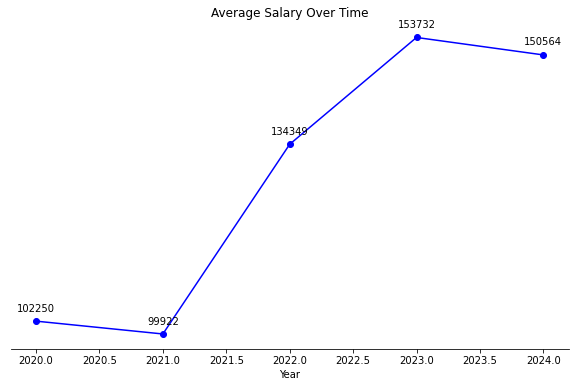

In [0]:
import matplotlib.pyplot as plt

# SQL query to get average salary over time
avg_salary_time_df = spark.sql("SELECT work_year, AVG(salary_in_usd) as avg_salary FROM salaries_table GROUP BY work_year ORDER BY work_year").toPandas()

# Creating the line chart
plt.figure(figsize=(10, 6))
plt.plot(avg_salary_time_df['work_year'], avg_salary_time_df['avg_salary'], marker='o', linestyle='-', color='b')

# Annotating the values on the line
for i, txt in enumerate(avg_salary_time_df['avg_salary']):
    plt.annotate(f'{int(txt)}', (avg_salary_time_df['work_year'][i], avg_salary_time_df['avg_salary'][i]), textcoords="offset points", xytext=(0, 10), ha='center')

# Customizing the plot
plt.xlabel('Year')
plt.ylabel('')  # Removing y-axis label
plt.title('Average Salary Over Time')

# Removing y-axis line and ticks
plt.gca().spines['left'].set_color('none')
plt.gca().spines['right'].set_color('none')
plt.gca().yaxis.set_ticks([])

# Removing the line under the title
plt.gca().spines['top'].set_color('none')

# Keeping x-axis elements
plt.gca().spines['bottom'].set_color('black')
plt.gca().xaxis.set_ticks_position('bottom')

# Removing grids
plt.grid(False)

# Showing the plot
plt.show()




Creating a bar chart to show the average salary by experience level

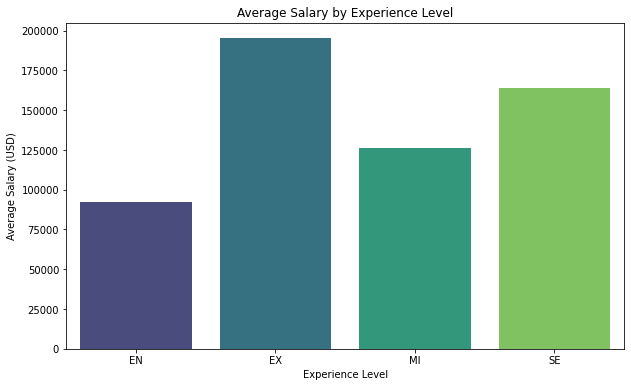

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# SQL query to get average salary by experience level
avg_salary_exp_df = spark.sql("SELECT experience_level, AVG(salary_in_usd) as avg_salary FROM salaries_table GROUP BY experience_level ORDER BY experience_level").toPandas()

# Creating the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='experience_level', y='avg_salary', data=avg_salary_exp_df, palette='viridis')

# Customizing the plot
plt.xlabel('Experience Level')
plt.ylabel('Average Salary (USD)')
plt.title('Average Salary by Experience Level')

# Showing the plot
plt.show()



Creating a horizontal stacked bar chart to show the remote work ratio and company size relationship

<Figure size 1008x720 with 0 Axes>

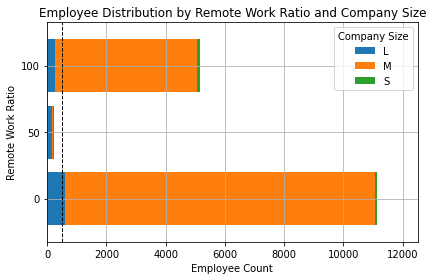

In [0]:
# Creating the df
remote_company_size_df = spark.sql("""
    SELECT 
        remote_ratio,
        company_size,
        COUNT(*) as count
    FROM 
        salaries_table 
    GROUP BY 
        remote_ratio,
        company_size
    ORDER BY
        remote_ratio,
        company_size
""").toPandas()

# Pivoting the dataframe for stacked bar chart
pivot_df = remote_company_size_df.pivot(index='remote_ratio', columns='company_size', values='count').fillna(0)

# Creating the horizontally stacked bar chart with extended bars
plt.figure(figsize=(14, 10))
ax = pivot_df.plot(kind='barh', stacked=True, width=0.8)  # Increasing the bar thickness
plt.ylabel('Remote Work Ratio')
plt.xlabel('Employee Count')
plt.title('Employee Distribution by Remote Work Ratio and Company Size')
plt.legend(title='Company Size', loc='upper right')  # Moving the legend to upper right
plt.grid(True)
plt.tight_layout()

# Extending the bars along the x-axis to a specific width
ax.set_xlim(0, 12500)  

# Extending the x-axis reference line
ax.axvline(x=500, color='black', linestyle='--', linewidth=1)

plt.show()






Creating a Horizontal Bar Chart to Show the Remote Work Ratio for Top 10 Job Titles with Highest Average Salary

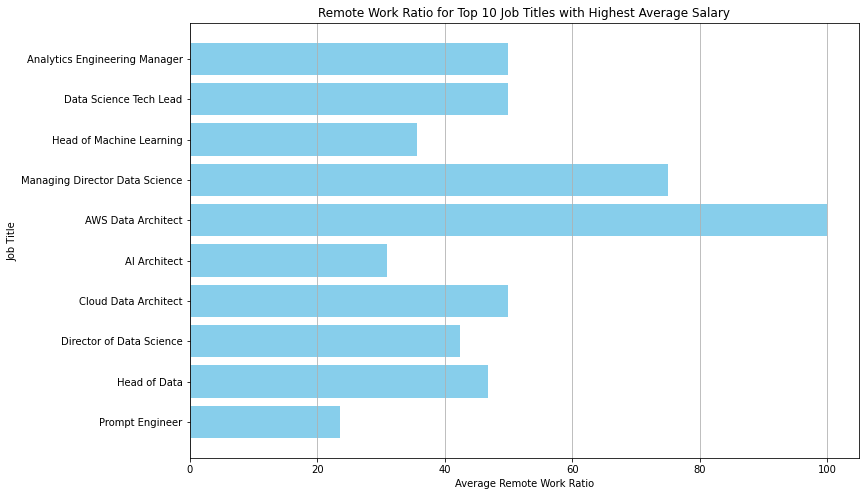

In [0]:
import pandas as pd

# Calculating average salary for each job title
avg_salary_df = spark.sql("""
    SELECT 
        job_title,
        AVG(salary_in_usd) as avg_salary
    FROM 
        salaries_table 
    GROUP BY 
        job_title
    ORDER BY 
        avg_salary DESC
    LIMIT 10
""").toPandas()

# Getting the remote work ratio for each job title
remote_ratio_df = spark.sql("""
    SELECT 
        job_title,
        AVG(remote_ratio) as avg_remote_ratio
    FROM 
        salaries_table 
    WHERE 
        job_title IN (SELECT job_title FROM salaries_table GROUP BY job_title ORDER BY AVG(salary_in_usd) DESC LIMIT 10)
    GROUP BY 
        job_title
""").toPandas()

# Merging average salary and remote work ratio dataframes
merged_df = pd.merge(avg_salary_df, remote_ratio_df, on='job_title')

# Sorting the merged dataframe by average salary
merged_df.sort_values(by='avg_salary', ascending=False, inplace=True)

# Creating bar chart comparing remote work ratio for top 10 job titles with highest average salary
plt.figure(figsize=(12, 8))
plt.barh(merged_df['job_title'], merged_df['avg_remote_ratio'], color='skyblue')
plt.xlabel('Average Remote Work Ratio')
plt.ylabel('Job Title')
plt.title('Remote Work Ratio for Top 10 Job Titles with Highest Average Salary')
plt.gca().invert_yaxis()  # Inverting the y-axis to display highest salary at the top
plt.grid(axis='x')
plt.show()


Creating a Bar Chart to Show Remote Work Ratio for Top 10 Countries with Most Records

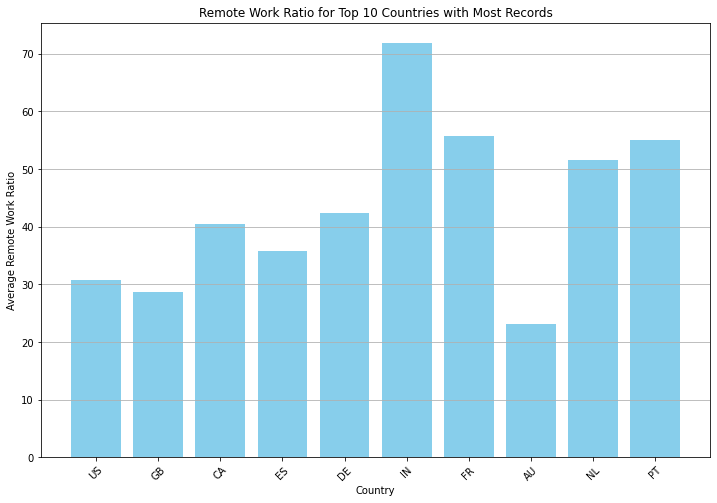

In [0]:
# Calculating count of records for each country
country_count_df = spark.sql("""
    SELECT 
        employee_residence AS country,
        COUNT(*) AS record_count
    FROM 
        salaries_table 
    GROUP BY 
        employee_residence
    ORDER BY 
        record_count DESC
    LIMIT 10
""").toPandas()

# Checking if the country_count_df dataframe is empty
if not country_count_df.empty:
    # Converting the country names to a string list
    country_list = "'" + "','".join(country_count_df['country'].tolist()) + "'"

    # Getting the remote work ratio for each country
    remote_ratio_df = spark.sql(f"""
        SELECT 
            employee_residence AS country,
            AVG(remote_ratio) AS avg_remote_ratio
        FROM 
            salaries_table 
        WHERE 
            employee_residence IN ({country_list})
        GROUP BY 
            employee_residence
    """).toPandas()

    # Merging the dataframes
    merged_df = pd.merge(country_count_df, remote_ratio_df, on='country')

    # Sorting the merged dataframe by record count
    merged_df.sort_values(by='record_count', ascending=False, inplace=True)

    # Creating the bar chart comparing remote work ratio for top 10 countries with most records
    plt.figure(figsize=(12, 8))
    plt.bar(merged_df['country'], merged_df['avg_remote_ratio'], color='skyblue')
    plt.xlabel('Country')
    plt.ylabel('Average Remote Work Ratio')
    plt.title('Remote Work Ratio for Top 10 Countries with Most Records')
    plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
    plt.grid(axis='y')
    plt.show()
else:
    print("No data found for country_count_df")




Creating a Scatter Plot for Comparing of Average Salary and Remote Work Ratio for Top 10 Countries by Average Salary

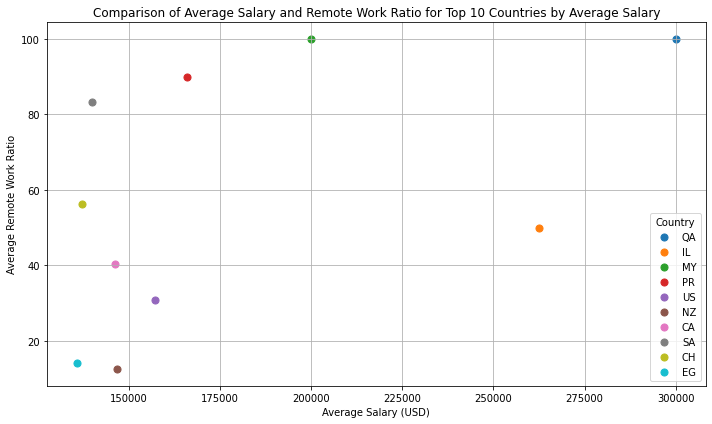

In [0]:
# Calculating average salary and remote work ratio for each country
country_stats_df = spark.sql("""
    SELECT 
        employee_residence AS country,
        AVG(salary_in_usd) AS avg_salary,
        AVG(remote_ratio) AS avg_remote_ratio
    FROM 
        salaries_table 
    GROUP BY 
        employee_residence
    ORDER BY 
        avg_salary DESC
    LIMIT 10
""").toPandas()

# Creating scatter plot
plt.figure(figsize=(10, 6))


for country in country_stats_df['country'].unique():
    country_data = country_stats_df[country_stats_df['country'] == country]
    plt.scatter(country_data['avg_salary'], country_data['avg_remote_ratio'], s=50, label=country)

plt.xlabel('Average Salary (USD)')
plt.ylabel('Average Remote Work Ratio')
plt.title('Comparison of Average Salary and Remote Work Ratio for Top 10 Countries by Average Salary')
plt.grid(True)
plt.legend(title='Country', loc='lower right')  
plt.tight_layout()  
plt.show()





## Applying Some Transformations on Dataset

Applying the filtering to select the records with salary greater than $100,000, select specific columns, limit the dataset to the first 10 records, and order the dataset by salary in descending order.


In [0]:
# Importing the necessary libraries
from pyspark.sql.functions import col

# Applying the filtering
filtered_df = df_auto.filter(col("salary_in_usd") > 100000)

# Selecting specific columns
selected_df = filtered_df.select("job_title", "salary_in_usd", "company_size")

# Limiting the dataset to the first 10 records
limited_df = selected_df.limit(10)

# Ordering the dataset by salary in descending order
ordered_df = limited_df.orderBy(col("salary_in_usd").desc())




Using the 'grouping' by using the different aggregation functions 

In [0]:
# Importing necessary PySpark SQL functions
from pyspark.sql.functions import avg, sum, count

# Grouping the DataFrame by job title and calculate average and total salary, and count of employees
grouped_df = df_auto.groupBy("job_title").agg(
    avg("salary_in_usd").alias("avg_salary"),
    sum("salary_in_usd").alias("total_salary"),
    count("*").alias("employee_count")
)


In [0]:
# Showing the grouped DataFrame
grouped_df.show()


+--------------------+------------------+------------+--------------+
|           job_title|        avg_salary|total_salary|employee_count|
+--------------------+------------------+------------+--------------+
|Business Intellig...|          137379.5|     1373795|            10|
|Director of Busin...|          187500.0|      375000|             2|
|Business Intellig...|114066.41884816754|    21786686|           191|
|  Lead Data Engineer|139230.33333333334|      835382|             6|
|Marketing Data Sc...|           90000.0|       90000|             1|
|        Data Modeler|130851.41071428571|     7327679|            56|
|        AI Architect|252551.24137931035|     7323986|            29|
|Data Integration ...|         140580.75|      562323|             4|
|Data Visualizatio...|112515.21428571429|     1575213|            14|
|       Bear Robotics|          167500.0|      335000|             2|
| Data Scientist Lead|          136153.0|      272306|             2|
|  Data Product Owne

Using different pyspark.sql.functions 

In [0]:
# Importing necessary PySpark SQL functions
from pyspark.sql.functions import min, max

# Calculating the minimum and maximum salaries for each job title
min_max_salaries_df = df_auto.groupBy("job_title").agg(
    min("salary_in_usd").alias("min_salary"),
    max("salary_in_usd").alias("max_salary")
)


In [0]:
min_max_salaries_df.show()

+--------------------+----------+----------+
|           job_title|min_salary|max_salary|
+--------------------+----------+----------+
|Business Intellig...|    104800|    187415|
|Director of Busin...|    175000|    200000|
|Business Intellig...|     40603|    234000|
|  Lead Data Engineer|     56000|    276000|
|Marketing Data Sc...|     90000|     90000|
|        Data Modeler|     55368|    258700|
|        AI Architect|     99750|    800000|
|Data Integration ...|    105267|    180000|
|Data Visualizatio...|     50000|    185000|
|       Bear Robotics|    120000|    215000|
| Data Scientist Lead|     89306|    183000|
|  Data Product Owner|     55926|    321830|
|  Decision Scientist|    123040|    204500|
|Data Analytics As...|     91000|     91000|
|Principal Data Ar...|     38154|     38154|
|Head of Machine L...|     76309|    448000|
|Machine Learning ...|     24322|    375000|
|Data Analytics Sp...|     44100|    157144|
|     Data Specialist|     38651|    224800|
|  Sales D

In [0]:
# Importing necessary PySpark SQL functions
from pyspark.sql.functions import approx_count_distinct, corr

# Calculating the approximate count of distinct job titles and the correlation coefficient
count_corr_company_size_df = df_auto.groupBy("company_size").agg(
    approx_count_distinct("job_title").alias("distinct_job_titles"),
    corr("salary_in_usd", "remote_ratio").alias("salary_remote_corr")
)


In [0]:
count_corr_company_size_df.show()

+------------+-------------------+--------------------+
|company_size|distinct_job_titles|  salary_remote_corr|
+------------+-------------------+--------------------+
|           M|                124|-0.03061802169005328|
|           L|                 95| -0.3091040026500792|
|           S|                 52| -0.0818193182548512|
+------------+-------------------+--------------------+



# Part 2

Creating a widget to filter the employee country

In [0]:
# Importing the necessary package
import ipywidgets as widgets

# Retrieving the unique list of employee countries from the DataFrame
employee_countries = df_auto.select("employee_residence").distinct().rdd.flatMap(lambda x: x).collect()

# Creating a dropdown widget for employee country selection
dbutils.widgets.dropdown("employee_country", employee_countries[0], employee_countries, "Employee Country")

# Retrieving the selected value from the widget
selected_country = dbutils.widgets.get("employee_country")

# Displaying the selected value
selected_country



Out[57]: 'IL'

Using the groupBy.agg function

In [0]:
# Grouping the DataFrame by experience_level and calculating the total salary and averaging remote_ratio for each experience level
agg_df = df_auto.groupBy("experience_level").agg({"salary_in_usd": "sum", "remote_ratio": "avg"})


display(agg_df)


experience_level avg(remote_ratio) sum(salary_in_usd) EX 36.02794411177645 97827405 MI 28.7518573551263 508477604 EN 31.0188679245283 122333823 SE 33.16776007497657 1746282355

Using the DataframeNAFunctions

In [0]:
# Filling the null values in the 'remote_ratio' column with the mean remote_ratio
# Importing the necessary function
from pyspark.sql.functions import mean

mean_remote_ratio = df_auto.select(mean("remote_ratio")).collect()[0][0]
filled_df = df_auto.fillna(mean_remote_ratio, subset=['remote_ratio'])

Writing one of our DataFrames in delta format to a folder under /tmp

In [0]:
# Writing DataFrame to Delta format with overwrite option
delta_path = "/tmp/delta_data"
filled_df.write.format("delta").mode("overwrite").save(delta_path)

# Listing the folder containing Delta files
dbutils.fs.ls(delta_path)

Out[60]: [FileInfo(path='dbfs:/tmp/delta_data/_delta_log/', name='_delta_log/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/tmp/delta_data/part-00000-19fcae3e-6d39-410b-8f0c-98ad6908455f-c000.snappy.parquet', name='part-00000-19fcae3e-6d39-410b-8f0c-98ad6908455f-c000.snappy.parquet', size=107933, modificationTime=1721308137000),
 FileInfo(path='dbfs:/tmp/delta_data/part-00000-35bed9f0-7bbb-4a65-965b-d62604680af3-c000.snappy.parquet', name='part-00000-35bed9f0-7bbb-4a65-965b-d62604680af3-c000.snappy.parquet', size=107933, modificationTime=1721308782000),
 FileInfo(path='dbfs:/tmp/delta_data/part-00000-635e5d8b-c86b-4fee-8202-2adb9fc31d3d-c000.snappy.parquet', name='part-00000-635e5d8b-c86b-4fee-8202-2adb9fc31d3d-c000.snappy.parquet', size=107933, modificationTime=1717286180000),
 FileInfo(path='dbfs:/tmp/delta_data/part-00000-766f54dd-6520-451c-954c-78e3841712d6-c000.snappy.parquet', name='part-00000-766f54dd-6520-451c-954c-78e3841712d6-c000.snappy.parquet', size=107933, modifica

Using the withColumn function

In [0]:
# Adding a new column 'is_full_time' based on employment_type
from pyspark.sql.functions import when

with_is_full_time_df = filled_df.withColumn("is_full_time", when(filled_df["employment_type"] == "FT", True).otherwise(False))

display(with_is_full_time_df)

work_year experience_level employment_type job_title salary salary_currency salary_in_usd employee_residence remote_ratio company_location company_size is_full_time 2024 SE FT AI Engineer 202730 USD 202730 US 0 US M true 2024 SE FT AI Engineer 92118 USD 92118 US 0 US M true 2024 SE FT Data Engineer 130500 USD 130500 US 0 US M true 2024 SE FT Data Engineer 96000 USD 96000 US 0 US M true 2024 SE FT Machine Learning Engineer 190000 USD 190000 US 0 US M true 2024 SE FT Machine Learning Engineer 160000 USD 160000 US 0 US M true 2024 MI FT ML Engineer 400000 USD 400000 US 0 US M true 2024 MI FT ML Engineer 65000 USD 65000 US 0 US M true 2024 EN FT Data Analyst 101520 USD 101520 US 0 US M true 2024 EN FT Data Analyst 45864 USD 45864 US 0 US M true 2024 SE FT Data Engineer 172469 USD 172469 US 0 US M true 2024 SE FT Data Engineer 114945 USD 114945 US 0 US M true 2024 EX FT NLP Engineer 200000 USD 200000 US 0 US M true 2024 EX FT NLP Engineer 150000 USD 150000 US 0 US M true 2024 MI FT Data Scientist 156450 USD 156450 US 100 US M true 2024 MI FT Data Scientist 119200 USD 119200 US 100 US M true 2024 SE FT Data Analyst 170000 USD 170000 US 0 US M true 2024 SE FT Data Analyst 130000 USD 130000 US 0 US M true 2024 SE FT Applied Scientist 222200 USD 222200 US 0 US L true 2024 SE FT Applied Scientist 136000 USD 136000 US 0 US L true 2024 MI FT Data Manager 128000 USD 128000 US 0 US M true 2024 MI FT Data Manager 81500 USD 81500 US 0 US M true 2024 SE FT Data Architect 93838 USD 93838 US 0 US M true 2024 SE FT Data Architect 69535 USD 69535 US 0 US M true 2024 EN FT Data Analyst 75000 USD 75000 US 0 US M true 2024 EN FT Data Analyst 65000 USD 65000 US 0 US M true 2024 MI FT Data Operations Manager 150000 USD 150000 US 0 US M true 2024 MI FT Data Operations Manager 125000 USD 125000 US 0 US M true 2024 MI FT Research Scientist 260570 USD 260570 US 0 US M true 2024 MI FT Research Scientist 167030 USD 167030 US 0 US M true 2024 EN FT Data Engineer 120000 USD 120000 US 0 US M true 2024 EN FT Data Engineer 100000 USD 100000 US 0 US M true 2024 SE FT Data Engineer 190000 USD 190000 US 100 US M true 2024 SE FT Data Engineer 155000 USD 155000 US 100 US M true 2024 SE FT Data Analyst 174000 USD 174000 US 100 US M true 2024 SE FT Data Analyst 116000 USD 116000 US 100 US M true 2024 MI FT Data Analyst 100000 USD 100000 US 0 US M true 2024 MI FT Data Analyst 80000 USD 80000 US 0 US M true 2024 MI FT Data Analyst 145000 USD 145000 US 0 US M true 2024 MI FT Data Analyst 95000 USD 95000 US 0 US M true 2024 MI FT Data Scientist 120000 USD 120000 AU 0 AU S true 2024 MI FT Data Scientist 70000 USD 70000 AU 0 AU S true 2024 MI CT Data Scientist 130000 USD 130000 US 0 US M false 2024 MI CT Data Scientist 110000 USD 110000 US 0 US M false 2024 MI FT Data Science Manager 240000 USD 240000 US 0 US M true 2024 MI FT Data Science Manager 180000 USD 180000 US 0 US M true 2024 SE FT Business Intelligence Engineer 202800 USD 202800 US 0 US M true 2024 SE FT Business Intelligence Engineer 115000 USD 115000 US 0 US M true 2024 SE FT Data Architect 80000 GBP 100000 GB 0 GB M true 2024 SE FT Data Architect 45000 GBP 56250 GB 0 GB M true 2024 SE FT Data Analyst 90000 CAD 69230 CA 0 CA M true 2024 SE FT Data Analyst 75000 CAD 57692 CA 0 CA M true 2024 MI FT Data Analyst 112300 USD 112300 US 0 US M true 2024 MI FT Data Analyst 75100 USD 75100 US 0 US M true 2024 MI FT Business Intelligence 178200 USD 178200 US 0 US M true 2024 MI FT Business Intelligence 87000 USD 87000 US 0 US M true 2024 SE FT Data Scientist 138000 USD 138000 CA 0 CA M true 2024 SE FT Data Scientist 72000 USD 72000 CA 0 CA M true 2024 MI FT ML Engineer 252000 USD 252000 US 0 US M true 2024 MI FT ML Engineer 168000 USD 168000 US 0 US M true 2024 SE FT Data Modeler 140000 USD 140000 US 100 US M true 2024 SE FT Data Modeler 130000 USD 130000 US 100 US M true 2024 SE FT Machine Learning Engineer 190000 USD 190000 US 0 US M true 2024 SE FT Machine Learning Engineer 100000 USD 100000 US 0 US M true 2024 MI FT Dat

Using the df.createOrReplaceTempView and the spark.table functions

In [0]:
# Creating a temporary view from DataFrame
filled_df.createOrReplaceTempView("employee_data")

# Retrieving DataFrame associated with temporary view
temp_view_df = spark.table("employee_data")
display(temp_view_df)

work_year experience_level employment_type job_title salary salary_currency salary_in_usd employee_residence remote_ratio company_location company_size 2024 SE FT AI Engineer 202730 USD 202730 US 0 US M 2024 SE FT AI Engineer 92118 USD 92118 US 0 US M 2024 SE FT Data Engineer 130500 USD 130500 US 0 US M 2024 SE FT Data Engineer 96000 USD 96000 US 0 US M 2024 SE FT Machine Learning Engineer 190000 USD 190000 US 0 US M 2024 SE FT Machine Learning Engineer 160000 USD 160000 US 0 US M 2024 MI FT ML Engineer 400000 USD 400000 US 0 US M 2024 MI FT ML Engineer 65000 USD 65000 US 0 US M 2024 EN FT Data Analyst 101520 USD 101520 US 0 US M 2024 EN FT Data Analyst 45864 USD 45864 US 0 US M 2024 SE FT Data Engineer 172469 USD 172469 US 0 US M 2024 SE FT Data Engineer 114945 USD 114945 US 0 US M 2024 EX FT NLP Engineer 200000 USD 200000 US 0 US M 2024 EX FT NLP Engineer 150000 USD 150000 US 0 US M 2024 MI FT Data Scientist 156450 USD 156450 US 100 US M 2024 MI FT Data Scientist 119200 USD 119200 US 100 US M 2024 SE FT Data Analyst 170000 USD 170000 US 0 US M 2024 SE FT Data Analyst 130000 USD 130000 US 0 US M 2024 SE FT Applied Scientist 222200 USD 222200 US 0 US L 2024 SE FT Applied Scientist 136000 USD 136000 US 0 US L 2024 MI FT Data Manager 128000 USD 128000 US 0 US M 2024 MI FT Data Manager 81500 USD 81500 US 0 US M 2024 SE FT Data Architect 93838 USD 93838 US 0 US M 2024 SE FT Data Architect 69535 USD 69535 US 0 US M 2024 EN FT Data Analyst 75000 USD 75000 US 0 US M 2024 EN FT Data Analyst 65000 USD 65000 US 0 US M 2024 MI FT Data Operations Manager 150000 USD 150000 US 0 US M 2024 MI FT Data Operations Manager 125000 USD 125000 US 0 US M 2024 MI FT Research Scientist 260570 USD 260570 US 0 US M 2024 MI FT Research Scientist 167030 USD 167030 US 0 US M 2024 EN FT Data Engineer 120000 USD 120000 US 0 US M 2024 EN FT Data Engineer 100000 USD 100000 US 0 US M 2024 SE FT Data Engineer 190000 USD 190000 US 100 US M 2024 SE FT Data Engineer 155000 USD 155000 US 100 US M 2024 SE FT Data Analyst 174000 USD 174000 US 100 US M 2024 SE FT Data Analyst 116000 USD 116000 US 100 US M 2024 MI FT Data Analyst 100000 USD 100000 US 0 US M 2024 MI FT Data Analyst 80000 USD 80000 US 0 US M 2024 MI FT Data Analyst 145000 USD 145000 US 0 US M 2024 MI FT Data Analyst 95000 USD 95000 US 0 US M 2024 MI FT Data Scientist 120000 USD 120000 AU 0 AU S 2024 MI FT Data Scientist 70000 USD 70000 AU 0 AU S 2024 MI CT Data Scientist 130000 USD 130000 US 0 US M 2024 MI CT Data Scientist 110000 USD 110000 US 0 US M 2024 MI FT Data Science Manager 240000 USD 240000 US 0 US M 2024 MI FT Data Science Manager 180000 USD 180000 US 0 US M 2024 SE FT Business Intelligence Engineer 202800 USD 202800 US 0 US M 2024 SE FT Business Intelligence Engineer 115000 USD 115000 US 0 US M 2024 SE FT Data Architect 80000 GBP 100000 GB 0 GB M 2024 SE FT Data Architect 45000 GBP 56250 GB 0 GB M 2024 SE FT Data Analyst 90000 CAD 69230 CA 0 CA M 2024 SE FT Data Analyst 75000 CAD 57692 CA 0 CA M 2024 MI FT Data Analyst 112300 USD 112300 US 0 US M 2024 MI FT Data Analyst 75100 USD 75100 US 0 US M 2024 MI FT Business Intelligence 178200 USD 178200 US 0 US M 2024 MI FT Business Intelligence 87000 USD 87000 US 0 US M 2024 SE FT Data Scientist 138000 USD 138000 CA 0 CA M 2024 SE FT Data Scientist 72000 USD 72000 CA 0 CA M 2024 MI FT ML Engineer 252000 USD 252000 US 0 US M 2024 MI FT ML Engineer 168000 USD 168000 US 0 US M 2024 SE FT Data Modeler 140000 USD 140000 US 100 US M 2024 SE FT Data Modeler 130000 USD 130000 US 100 US M 2024 SE FT Machine Learning Engineer 190000 USD 190000 US 0 US M 2024 SE FT Machine Learning Engineer 100000 USD 100000 US 0 US M 2024 MI FT Data Scientist 150650 USD 150650 US 0 US M 2024 MI FT Data Scientist 106700 USD 106700 US 0 US M 2024 SE FT Data Scientist 192300 USD 192300 US 0 US M 2024 SE FT Data Scientist 107900 USD 107900 US 0 US M 2024 MI FT Data Integration Specialist 115000 USD 115000 US 100 US M 2024 MI FT Data Integration Specialist 95500 USD 95500 US 100 US

# Part 3

Disabling the adaptive query executor 

In [0]:
spark.conf.set('spark.sql.adaptive.enabled', 'false')

Displaying the number of partitions in the input DataFrame and executing a `.count()` to check the number of partitions in the Spark UI.

In [0]:
# Displaying the number of partitions in the input DataFrame
num_partitions = df_auto.rdd.getNumPartitions()
print(f"Number of partitions: {num_partitions}")

Number of partitions: 1


In [0]:
# Executing a count on the DataFrame
df_auto_count = df_auto.count()
print(f"Count: {df_auto_count}")

Count: 16534


**Observations**:
- **Number of Partitions**: The input DataFrame `df_auto` has 1 partition.
- **Count**: The DataFrame contains 16534 records.

### Spark UI Screenshot and Analysis

![Spark UI Screenshot](https://spark-class-datasets.s3.eu-west-1.amazonaws.com/ceu_spark_class_datasets/data_engineer_salaries/sparkuı_ss.png)



**Spark UI Analysis**:
- The stages in the Spark UI correspond to the reading of the input data and performing the count operation.
- The metrics for `Scan CSV` show the reading of 16534 records, matching the count in the DataFrame.
- No data shuffling occurred, as indicated by the single partition and lack of `Exchange` activity.


### Comparison with DataFrame Partitions and Count
- The DataFrame was observed to have 1 partition, as reported by `getNumPartitions()`.
- The count of the DataFrame was found to be 16,534 rows.

It seems that the DataFrame we're working with has only one partition, as indicated by the output of getNumPartitions() method. However, the count of the DataFrame indicates that there are 16,534 rows.

Looking at the execution plan, it appears that Spark read the data from a CSV file using the "Scan csv" stage. The metrics show that there is only one partition for this stage, which matches the number of partitions reported in the notebook.

However, the difference arises when considering the count of rows. The count of 16,534 rows suggests that Spark read and processed all the rows in the DataFrame, but it was done within a single partition. This is possible for small datasets or when Spark optimizes execution. In larger datasets, Spark may distribute the data across multiple partitions for parallel processing, but for smaller datasets, it may choose to process the data within a single partition for efficiency.

In this case, it seems Spark chose to read the data into a single partition, likely due to the small size of the dataset. This decision optimized the processing without the need for parallelism.

**As for optimizations seen in the execution plan:**

**WholeStageCodegen:** This optimization compiles the entire query pipeline into a single function, which can significantly improve performance by reducing function call overhead.

**HashAggregate:** This is an optimization for aggregation operations, which likely occurred after reading the data from the CSV file. The aggregation build time was relatively fast (0 ms) for this operation.

**Exchange:** This stage likely involves shuffling data between partitions, which may be necessary for certain operations such as joins or aggregations. In this case, there's only one partition involved, so the shuffle overhead is minimal.

Overall, Spark's optimization strategies seem to be working efficiently for this particular DataFrame and query.


### Explain Plan

In [0]:
df_auto.explain(True)

== Parsed Logical Plan ==
Relation [work_year#4116,experience_level#4117,employment_type#4118,job_title#4119,salary#4120,salary_currency#4121,salary_in_usd#4122,employee_residence#4123,remote_ratio#4124,company_location#4125,company_size#4126] csv

== Analyzed Logical Plan ==
work_year: int, experience_level: string, employment_type: string, job_title: string, salary: int, salary_currency: string, salary_in_usd: int, employee_residence: string, remote_ratio: int, company_location: string, company_size: string
Relation [work_year#4116,experience_level#4117,employment_type#4118,job_title#4119,salary#4120,salary_currency#4121,salary_in_usd#4122,employee_residence#4123,remote_ratio#4124,company_location#4125,company_size#4126] csv

== Optimized Logical Plan ==
Relation [work_year#4116,experience_level#4117,employment_type#4118,job_title#4119,salary#4120,salary_currency#4121,salary_in_usd#4122,employee_residence#4123,remote_ratio#4124,company_location#4125,company_size#4126] csv

== Physica

1. **Parsed Logical Plan:** The Parsed Logical Plan represents the initial logical plan generated by Spark after parsing the input query. It outlines the schema of the DataFrame and the operations to be performed.

2. **Analyzed Logical Plan:** In the Analyzed Logical Plan, Spark performs schema inference and type checking, resulting in a refined schema with data types assigned to each column.

3. **Optimized Logical Plan:** The Optimized Logical Plan shows any logical optimizations applied by Spark. In this case, it appears that no additional logical optimizations were performed, as the plan remains the same as the Analyzed Logical Plan.

4. **Physical Plan:** The Physical Plan outlines the actual physical execution steps that Spark will take to execute the query. Here, we see a FileScan operation, indicating that Spark will read data from a CSV file. The **Batched** parameter is set to false, meaning that Spark will not batch the data reading process. Additionally, there are no DataFilters or PartitionFilters applied, indicating that no specific filtering or partitioning is being performed during the read operation.

**Observations:**
- The execution plan consists of a straightforward FileScan operation without any additional optimizations applied.
- Since there are no PushedFilters or PartitionFilters, it suggests that Spark is reading the entire dataset without applying any filters or partitioning strategies during the read operation.
- While the execution plan is simple in this case, for more complex queries or larger datasets, Spark may apply various optimizations such as predicate pushdown, filter pushdown, or partition pruning to improve query performance.

### Performance Analysis Based on Executors Metrics

The metrics in the Executors section provide valuable insights into the performance and optimization status of the Spark application:

- **RDD Blocks**: 2 RDD blocks indicate the distribution and utilization of data in memory. More RDD blocks may imply higher memory usage and potentially better performance.
- **Storage Memory**: The usage of 90.3 KiB of memory shows the amount of memory Spark uses for caching data. More available memory allows for more data to be cached and reused.
- **Cores**: With 8 cores available, the application can execute a certain number of tasks simultaneously. More cores mean more parallel processing capacity.
- **Active Tasks**: 4032 active tasks indicate the parallelism and execution status of the application. A high number of active tasks suggests efficient utilization of resources.
- **Task Time (GC Time)**: The task time and GC time metrics reveal how long tasks take to complete and how much of that time is spent on garbage collection (GC). Only 8 seconds out of the total 31 minutes of task time were spent on GC, indicating effective optimization of the application.

Based on these metrics, we can evaluate the performance of the Spark application and determine whether it has been effectively optimized.

Additionally, please find the screenshot of the Executors section for further reference: 

![Executors Screenshot](https://spark-class-datasets.s3.eu-west-1.amazonaws.com/ceu_spark_class_datasets/data_engineer_salaries/executers.png)

This screenshot provides additional insights into the resource allocation and task distribution of the Spark application.
